In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from keras.layers import Input, Dense, Flatten, Reshape, LSTM, Dropout
from keras.models import Model, Sequential
import keras
from sklearn.metrics import mean_squared_error, classification_report, precision_recall_curve
import seaborn as sns
from tqdm import tqdm
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

In [2]:
def plot_pr_curve(y_true, prediction):
    plt.figure(figsize=(12,9))
    precision, recall, thresholds = precision_recall_curve(y_true, prediction)
    thresholds = [0] + thresholds.tolist()
    plt.plot(thresholds, precision, label='precision');
    plt.plot(thresholds, recall, label='recall');
    plt.legend(fontsize=16); plt.xlabel('Threshold', fontsize=16); #plt.ylabel('Precision or recall');
    plt.title('Precision и recall кривые для класса 1', fontsize=16);

In [3]:
def plot_train_val_loss(history, epochs):
    history_dict = history.history
    loss_values = history_dict['loss']
    val_loss_values = history_dict['val_loss']
    
    epochs = range(1, epochs + 1)

    plt.plot(epochs, loss_values, 'bo', label='Training loss')
    plt.plot(epochs, val_loss_values, 'b', label='Validation loss')

    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

In [4]:
%%time
df = pd.read_csv('dep_delay_df.csv')
df.drop(['YEAR','FLIGHTS', 'DEP_DELAY_GROUP'], axis=1, inplace=True)
df.FIRST_DEP_TIME.fillna(0, inplace=True)
#flights.TOTAL_ADD_GTIME.fillna(0, inplace=True)
df.LONGEST_ADD_GTIME.fillna(0, inplace=True)
#df.drop('LONGEST_ADD_GTIME', axis=1, inplace=True)
df.drop('TOTAL_ADD_GTIME', axis=1, inplace=True)
#df.drop('FIRST_DEP_TIME', axis=1, inplace=True)
df.STD_DELAY.fillna(0, inplace=True)
df.MEAN_DELAY.fillna(0, inplace=True)
df.MAX_DELAY.fillna(0, inplace=True)
df.MIN_DELAY.fillna(0, inplace=True)
df.COUNT.fillna(0, inplace=True)
df['25%_DELAY'].fillna(0, inplace=True)
df['50%_DELAY'].fillna(0, inplace=True)
df['75%_DELAY'].fillna(0, inplace=True)
df.dropna(inplace=True)

CPU times: user 26.4 s, sys: 18.1 s, total: 44.5 s
Wall time: 54.3 s


In [5]:
#for i in df.columns.to_list():
#    print(i)

In [6]:
def fill_dep_delay(x):
    if x >= 15:
        return 1
    return 0

In [7]:
print(df.shape)
df.head()

(4738774, 55)


,MONTH,DAY,DAY_OF_WEEK,AIRLINE,TAIL_NUM,FLIGHT_MUNBER,ORIGIN,ORIGIN_CITY_NAME,DEST,DEST_CITY_NAME,...,WEEKEND,LATE_AIRLINE_INDEX,LATE_TAIL_INDEX,LATE_ARR,IN_FLIGHTS_H,OUT_FLIGHTS_H,LATE_DEP_1,LATE_DEP_2,LATE_DEP_3,LATE_DEP_4
0,4,23,4,805608,907675,165,786276,86124,230321,679992,...,0,0.119103,0.108824,0.0,38,66,0.0,0.0,0.0,0.0
1,4,24,5,805608,625140,165,786276,86124,230321,679992,...,0,0.119103,0.123330,0.0,37,65,1.0,1.0,0.0,0.0
2,4,25,6,805608,140380,165,786276,86124,230321,679992,...,1,0.119103,0.136511,0.0,33,53,0.0,1.0,0.0,0.0
3,4,26,7,805608,869737,165,786276,86124,230321,679992,...,1,0.119103,0.110572,0.0,37,63,0.0,1.0,1.0,0.0
4,4,27,1,805608,556272,165,786276,86124,230321,679992,...,0,0.119103,0.119418,1.0,38,66,1.0,1.0,0.0,0.0


In [8]:
df['DEP_DELAY'] = df['DEP_DELAY'].apply(fill_dep_delay)
#df['target'] = df['DEP_DELAY'].apply(fill_dep_delay)

In [9]:
scaler = MinMaxScaler()

### Тестирование модели

In [10]:
df.iloc[:,11]

0          0
1          0
2          1
3          0
4          0
          ..
5714003    0
5714004    0
5714005    0
5714006    0
5714007    0
Name: DEP_DELAY, Length: 4738774, dtype: int64

In [11]:
y = df['target']
df['delay'] = df['DEP_DELAY']
df.drop(['target', 'DEP_DELAY'], axis=1, inplace=True)
x_train, x_test, y_train, y_test = train_test_split(df, y, random_state=42, stratify=y)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, random_state=42, stratify=y_train)

#x_train = scaler.fit_transform(x_train)
#x_test = scaler.transform(x_test)
#x_val = scaler.transform(x_val)

In [12]:
df.head()

,MONTH,DAY,DAY_OF_WEEK,AIRLINE,TAIL_NUM,FLIGHT_MUNBER,ORIGIN,ORIGIN_CITY_NAME,DEST,DEST_CITY_NAME,...,LATE_AIRLINE_INDEX,LATE_TAIL_INDEX,LATE_ARR,IN_FLIGHTS_H,OUT_FLIGHTS_H,LATE_DEP_1,LATE_DEP_2,LATE_DEP_3,LATE_DEP_4,delay
0,4,23,4,805608,907675,165,786276,86124,230321,679992,...,0.119103,0.108824,0.0,38,66,0.0,0.0,0.0,0.0,-8.0
1,4,24,5,805608,625140,165,786276,86124,230321,679992,...,0.119103,0.123330,0.0,37,65,1.0,1.0,0.0,0.0,4.0
2,4,25,6,805608,140380,165,786276,86124,230321,679992,...,0.119103,0.136511,0.0,33,53,0.0,1.0,0.0,0.0,44.0
3,4,26,7,805608,869737,165,786276,86124,230321,679992,...,0.119103,0.110572,0.0,37,63,0.0,1.0,1.0,0.0,-5.0
4,4,27,1,805608,556272,165,786276,86124,230321,679992,...,0.119103,0.119418,1.0,38,66,1.0,1.0,0.0,0.0,9.0


In [23]:
%%time
model = Sequential()
model.add(Dense(48, activation='relu', input_shape=(x_train.shape[1]-1,), kernel_initializer='he_normal'))
model.add(Dense(48, activation='relu', kernel_initializer='he_normal'))
model.add(Dense(1, activation='sigmoid', kernel_initializer='glorot_normal'))
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0003), loss='binary_crossentropy')
history_9 = model.fit(scaler.fit_transform(x_train.iloc[:,:-1]),
                      y_train, epochs=100, 
                      validation_data=(scaler.transform(x_test.iloc[:,:-1]), y_test), batch_size=512)

Epoch 1/100
5207/5207 [==============================] - 12s 2ms/step - loss: 0.3817 - val_loss: 0.3502
Epoch 2/100
5207/5207 [==============================] - 11s 2ms/step - loss: 0.3500 - val_loss: 0.3479
Epoch 3/100
5207/5207 [==============================] - 12s 2ms/step - loss: 0.3478 - val_loss: 0.3465
Epoch 4/100
5207/5207 [==============================] - 12s 2ms/step - loss: 0.3466 - val_loss: 0.3457
Epoch 5/100
5207/5207 [==============================] - 13s 2ms/step - loss: 0.3463 - val_loss: 0.3464
Epoch 6/100
5207/5207 [==============================] - 13s 2ms/step - loss: 0.3457 - val_loss: 0.3447
Epoch 7/100
5207/5207 [==============================] - 13s 2ms/step - loss: 0.3449 - val_loss: 0.3444
Epoch 8/100
5207/5207 [==============================] - 12s 2ms/step - loss: 0.3437 - val_loss: 0.3439
Epoch 9/100
5207/5207 [==============================] - 12s 2ms/step - loss: 0.3428 - val_loss: 0.3434
Epoch 10/100
5207/5207 [==============================] - 13s 2m

5207/5207 [==============================] - 11s 2ms/step - loss: 0.3376 - val_loss: 0.3387
Epoch 80/100
5207/5207 [==============================] - 11s 2ms/step - loss: 0.3377 - val_loss: 0.3388
Epoch 81/100
5207/5207 [==============================] - 11s 2ms/step - loss: 0.3374 - val_loss: 0.3389
Epoch 82/100
5207/5207 [==============================] - 11s 2ms/step - loss: 0.3369 - val_loss: 0.3390
Epoch 83/100
5207/5207 [==============================] - 11s 2ms/step - loss: 0.3373 - val_loss: 0.3391
Epoch 84/100
5207/5207 [==============================] - 11s 2ms/step - loss: 0.3372 - val_loss: 0.3387
Epoch 85/100
5207/5207 [==============================] - 11s 2ms/step - loss: 0.3369 - val_loss: 0.3386
Epoch 86/100
5207/5207 [==============================] - 11s 2ms/step - loss: 0.3371 - val_loss: 0.3386
Epoch 87/100
5207/5207 [==============================] - 11s 2ms/step - loss: 0.3371 - val_loss: 0.3387
Epoch 88/100
5207/5207 [==============================] - 11s 2ms/st

In [24]:
#scaler.fit_transform(x_train.iloc[:,:-1])

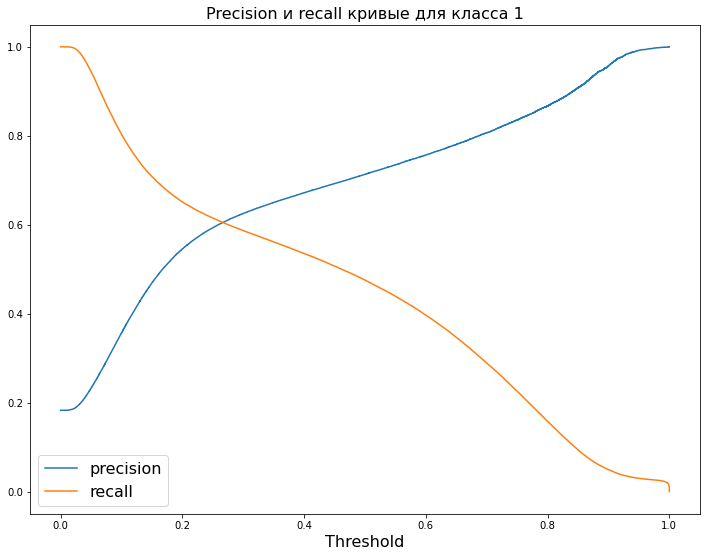

In [25]:
plot_pr_curve(y_val, model.predict(scaler.transform(x_val.iloc[:,:-1])))

In [26]:
p_network = model.predict(scaler.transform(x_val.iloc[:,:-1]))

In [29]:
def asd(x):
    if x > 0.4:
        return 1
    return 0

test_score = []
for i in tqdm(range(len(y_val))):
    test_score.append(asd(p_network[i]))

print(classification_report(y_val, test_score))

100%|██████████| 888520/888520 [00:02<00:00, 424705.71it/s]


              precision    recall  f1-score   support

           0       0.90      0.94      0.92    726259
           1       0.67      0.54      0.60    162261

    accuracy                           0.87    888520
   macro avg       0.79      0.74      0.76    888520
weighted avg       0.86      0.87      0.86    888520



In [28]:
x_val.shape

(888520, 55)

In [19]:
len(test_score)

888520

In [19]:
x_val['Predicted class'] = test_score

In [22]:
x_val.head()

,MONTH,DAY,DAY_OF_WEEK,AIRLINE,TAIL_NUM,FLIGHT_MUNBER,ORIGIN,ORIGIN_CITY_NAME,DEST,DEST_CITY_NAME,...,LATE_TAIL_INDEX,LATE_ARR,IN_FLIGHTS_H,OUT_FLIGHTS_H,LATE_DEP_1,LATE_DEP_2,LATE_DEP_3,LATE_DEP_4,delay,Predicted class
0,10,20,2,947883,898911,1463,76199,621973,683189,655877,...,0.168182,0.0,53,22,0.0,0.0,0.0,0.0,-4.0,0
1,7,28,2,900727,145919,2351,733918,909223,683189,655877,...,0.083455,0.0,64,6,0.0,0.0,0.0,0.0,1.0,0
2,4,10,5,288778,781316,290,579765,114493,884163,477863,...,0.201385,0.0,7,34,1.0,1.0,0.0,1.0,1.0,0
3,7,28,2,900727,69534,1272,683189,655877,465195,289028,...,0.086420,0.0,5,90,1.0,1.0,0.0,0.0,-1.0,0
4,9,27,7,805608,841103,1963,230321,679992,132869,964690,...,0.094996,0.0,18,28,0.0,0.0,0.0,0.0,5.0,0


In [83]:
x_val.to_csv('testing_df.csv', index=False)

In [21]:
x_val = pd.read_csv('testing_df.csv')

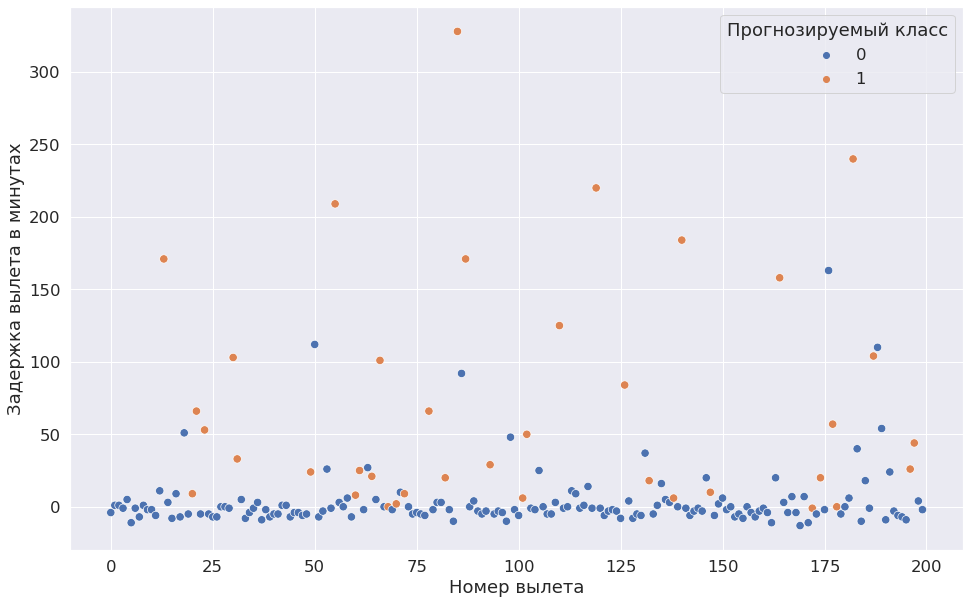

In [34]:
plt.figure(figsize=(16,10))
plt.ylabel('Задержка вылета в минутах', fontsize=18)
plt.xlabel('Номер вылета', fontsize=18)
sns.set(font_scale=1.5)
scat = sns.scatterplot(x=range(200), y=x_val.iloc[:200,-2], hue=x_val.iloc[:200, -1], s=70, cmap='coolwarm')
scat.legend(title='Прогнозируемый класс')

<AxesSubplot:ylabel='Departure Delay'>

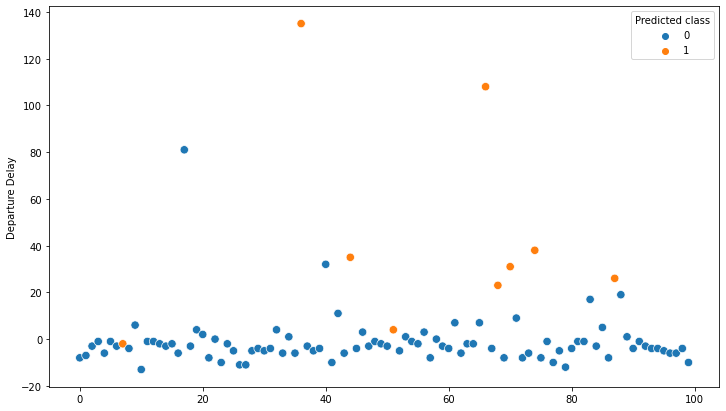

In [81]:
plt.figure(figsize=(12,7))
plt.ylabel('Departure Delay')
sns.scatterplot(x=range(100), y=x_val.iloc[1000:1100,-2], hue=x_val.iloc[1000:1100, -1], s=70, cmap='coolwarm')

<AxesSubplot:ylabel='Departure Delay'>

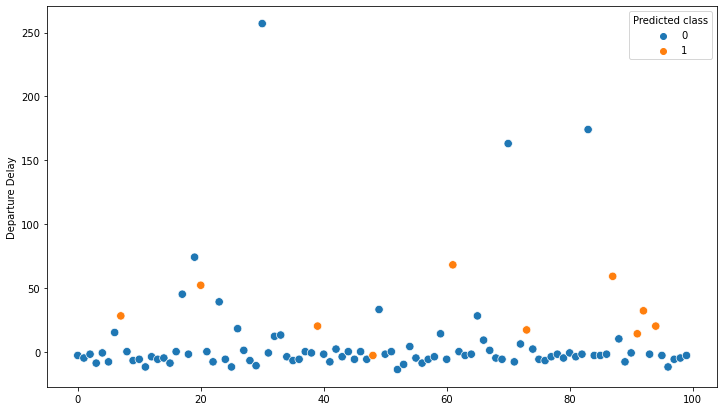

In [82]:
plt.figure(figsize=(12,7))
plt.ylabel('Departure Delay')
sns.scatterplot(x=range(100), y=x_val.iloc[2000:2100,-2], hue=x_val.iloc[2000:2100, -1], s=70, cmap='coolwarm')

In [11]:
y = df.DEP_DELAY
df.drop('DEP_DELAY', axis=1, inplace=True)

In [12]:
x_train, x_test, y_train, y_test = train_test_split(df, y, random_state=42, stratify=y)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, random_state=42, stratify=y_train)

In [13]:
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)
x_val = scaler.transform(x_val)

### Попробуем простой классификатор на основе полносвязной нейронной сети

In [14]:
epochs = 50

In [13]:
a = np.reshape(x_train, (x_train.shape[0], 1, x_train.shape[1]))

In [44]:
model = Sequential()
model.add(LSTM(units=48, input_shape=(1, x_train.shape[1]), activation='relu', kernel_initializer='he_normal'))
model.add(Dense(38, activation='relu', kernel_initializer='he_normal', input_shape=(x_train.shape[1],)))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid', kernel_initializer='glorot_normal'))
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss='binary_crossentropy')
history_1 = model.fit(a, y_train, epochs=50, validation_split=0.2, batch_size=256)

Epoch 1/100
8330/8330 [==============================] - 46s 5ms/step - loss: 0.3691 - val_loss: 0.3496
Epoch 2/100
8330/8330 [==============================] - 44s 5ms/step - loss: 0.3492 - val_loss: 0.3457
Epoch 3/100
8330/8330 [==============================] - 43s 5ms/step - loss: 0.3458 - val_loss: 0.3446
Epoch 4/100
8330/8330 [==============================] - 42s 5ms/step - loss: 0.3459 - val_loss: 0.3457
Epoch 5/100
8330/8330 [==============================] - 44s 5ms/step - loss: 0.3446 - val_loss: 0.3437
Epoch 6/100
8330/8330 [==============================] - 44s 5ms/step - loss: 0.3453 - val_loss: 0.3444
Epoch 7/100
8330/8330 [==============================] - 44s 5ms/step - loss: 0.3440 - val_loss: 0.3440
Epoch 8/100
8330/8330 [==============================] - 44s 5ms/step - loss: 0.3427 - val_loss: 0.3431
Epoch 9/100
8330/8330 [==============================] - 44s 5ms/step - loss: 0.3427 - val_loss: 0.3428
Epoch 10/100
8330/8330 [==============================] - 44s 5m

8330/8330 [==============================] - 25s 3ms/step - loss: 0.3382 - val_loss: 0.3388
Epoch 80/100
8330/8330 [==============================] - 25s 3ms/step - loss: 0.3381 - val_loss: 0.3404
Epoch 81/100
8330/8330 [==============================] - 24s 3ms/step - loss: 0.3378 - val_loss: 0.3404
Epoch 82/100
8330/8330 [==============================] - 24s 3ms/step - loss: 0.3382 - val_loss: 0.3394
Epoch 83/100
8330/8330 [==============================] - 24s 3ms/step - loss: 0.3375 - val_loss: 0.3389
Epoch 84/100
8330/8330 [==============================] - 25s 3ms/step - loss: 0.3374 - val_loss: 0.3397
Epoch 85/100
8330/8330 [==============================] - 24s 3ms/step - loss: 0.3366 - val_loss: 0.3397
Epoch 86/100
8330/8330 [==============================] - 24s 3ms/step - loss: 0.3378 - val_loss: 0.3390
Epoch 87/100
8330/8330 [==============================] - 24s 3ms/step - loss: 0.3380 - val_loss: 0.3390
Epoch 88/100
8330/8330 [==============================] - 25s 3ms/st

In [45]:
p_network = model.predict(np.reshape(x_val, (x_val.shape[0], 1, x_val.shape[1])))

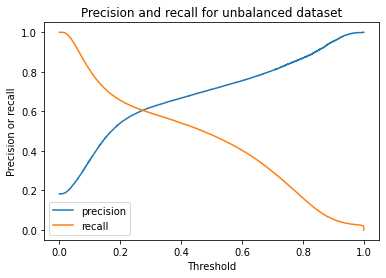

In [46]:
plot_pr_curve(y_val, p_network)

In [1]:
#plot_train_val_loss(history_1, 50)

In [22]:
model = Sequential()
model.add(Dense(32, activation='sigmoid', input_shape=(x_train.shape[1],)))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.1), loss='binary_crossentropy')
history_1 = model.fit(x_train, y_train, epochs=epochs, validation_data=(x_test, y_test), batch_size=256)

Epoch 1/50
10413/10413 [==============================] - 30s 3ms/step - loss: 0.3625 - val_loss: 0.3559
Epoch 2/50
10413/10413 [==============================] - 26s 3ms/step - loss: 0.3555 - val_loss: 0.3541
Epoch 3/50
10413/10413 [==============================] - 26s 3ms/step - loss: 0.3544 - val_loss: 0.3699
Epoch 4/50
10413/10413 [==============================] - 26s 3ms/step - loss: 0.3543 - val_loss: 0.3526
Epoch 5/50
10413/10413 [==============================] - 26s 3ms/step - loss: 0.3538 - val_loss: 0.3531
Epoch 6/50
10413/10413 [==============================] - 26s 3ms/step - loss: 0.3534 - val_loss: 0.3526
Epoch 7/50
10413/10413 [==============================] - 26s 3ms/step - loss: 0.3539 - val_loss: 0.3508
Epoch 8/50
10413/10413 [==============================] - 27s 3ms/step - loss: 0.3542 - val_loss: 0.3514
Epoch 9/50
10413/10413 [==============================] - 26s 3ms/step - loss: 0.3533 - val_loss: 0.3521
Epoch 10/50
10413/10413 [==============================

KeyboardInterrupt: 

#### learning_rate = 0.01

In [ ]:
model = Sequential()
model.add(Dense(32, activation='sigmoid', input_shape=(x_train.shape[1],)))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.01), loss='binary_crossentropy')
history_2 = model.fit(x_train, y_train, epochs=epochs, validation_data=(x_test, y_test), batch_size=256)

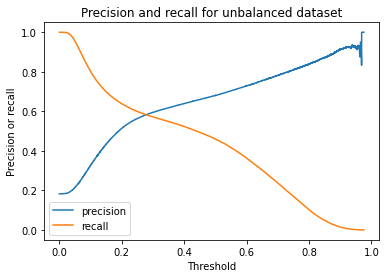

In [19]:
plot_pr_curve(y_val, model.predict(x_val))

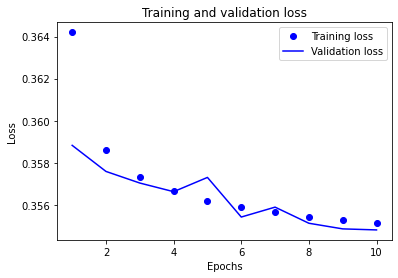

In [20]:
plot_train_val_loss(history_2, epochs)

#### learning_rate = 0.001

In [ ]:
model = Sequential()
model.add(Dense(32, activation='sigmoid', input_shape=(x_train.shape[1],)))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss='binary_crossentropy')
history_3 = model.fit(x_train, y_train, epochs=epochs, validation_data=(x_test, y_test), batch_size=256)

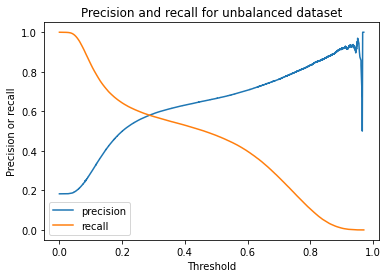

In [22]:
plot_pr_curve(y_val, model.predict(x_val))

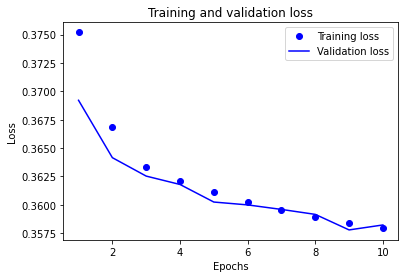

In [23]:
plot_train_val_loss(history_3, epochs)

В двух последних вариантах наблюдается переобучение. Попробуем изменить функцию активации скрытого слоя и увеличить количество эпох

#### activation = relu
#### learning_rate = 0.01

In [24]:
epochs = 20

In [ ]:
model = Sequential()
model.add(Dense(32, activation='relu', input_shape=(x_train.shape[1],)))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.01), loss='binary_crossentropy')
history_4 = model.fit(x_train, y_train, epochs=epochs, validation_data=(x_test, y_test), batch_size=256)

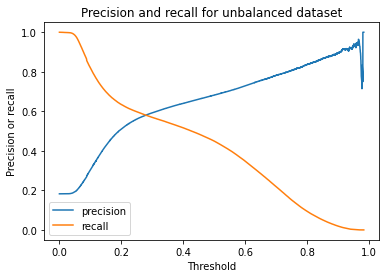

In [26]:
plot_pr_curve(y_val, model.predict(x_val))

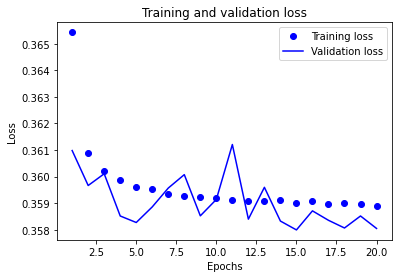

In [27]:
plot_train_val_loss(history_4, epochs)

#### activation = relu
#### learning_rate = 0.001

In [ ]:
model = Sequential()
model.add(Dense(32, activation='relu', input_shape=(x_train.shape[1],)))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss='binary_crossentropy')
history_5 = model.fit(x_train, y_train, epochs=epochs, validation_data=(x_test, y_test), batch_size=256)

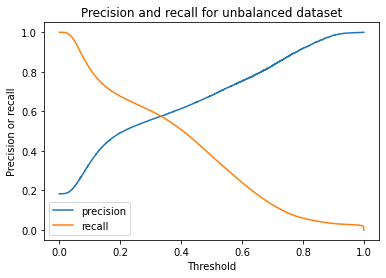

In [51]:
plot_pr_curve(y_val, model.predict(x_val))

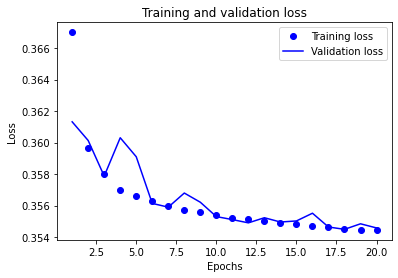

In [52]:
plot_train_val_loss(history_5, epochs)

Остановимся на последнем варианте. Попробуем изменить количество нейронов скрытого слоя

#### 48 Нейронов

In [ ]:
model = Sequential()
model.add(Dense(48, activation='relu', input_shape=(x_train.shape[1],)))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss='binary_crossentropy')
history_6 = model.fit(x_train, y_train, epochs=epochs, validation_data=(x_test, y_test), batch_size=256)

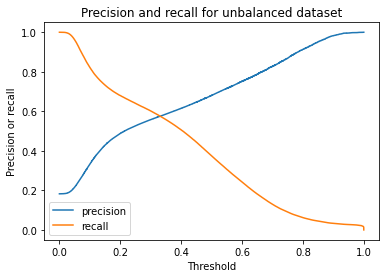

In [55]:
plot_pr_curve(y_val, model.predict(x_val))

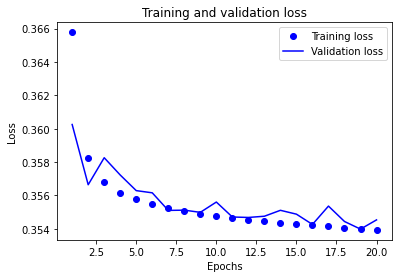

In [56]:
plot_train_val_loss(history_6, epochs)

#### 64 Нейронов

In [ ]:
model = Sequential()
model.add(Dense(64, activation='relu', input_shape=(x_train.shape[1],)))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss='binary_crossentropy')
history_7 = model.fit(x_train, y_train, epochs=epochs, validation_data=(x_test, y_test), batch_size=256)

In [ ]:
plot_pr_curve(y_val, model.predict(x_val))

In [ ]:
plot_train_val_loss(history_7, epochs)

### Классификатор из двух скрытых слоёв

In [ ]:
model = Sequential()
model.add(Dense(32, activation='sigmoid', input_shape=(x_train.shape[1],)))
model.add(Dense(32, activation='sigmoid'))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss='binary_crossentropy')
history_8 = model.fit(x_train, y_train, epochs=epochs, validation_data=(x_test, y_test), batch_size=256)

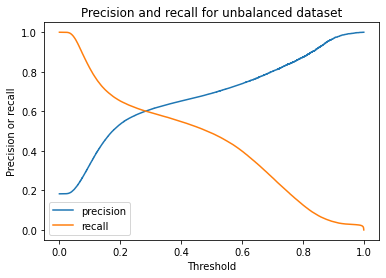

In [15]:
plot_pr_curve(y_val, model.predict(x_val))

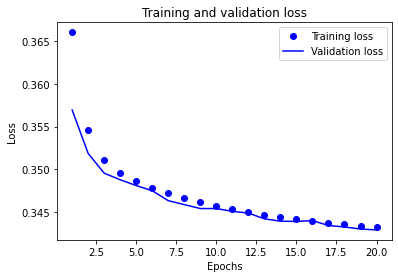

In [16]:
plot_train_val_loss(history_8, epochs)

#### activation = relu

In [15]:
from keras.layers import LeakyReLU, BatchNormalization

In [15]:
%%time
model = Sequential()
model.add(Dense(32, activation='relu', input_shape=(x_train.shape[1],)))
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss='binary_crossentropy')
history_1 = model.fit(x_train, y_train, epochs=50, validation_data=(x_test, y_test), batch_size=256)

Epoch 1/50
10413/10413 [==============================] - 32s 3ms/step - loss: 0.3643 - val_loss: 0.3469
Epoch 2/50
10413/10413 [==============================] - 29s 3ms/step - loss: 0.3465 - val_loss: 0.3451
Epoch 3/50
10413/10413 [==============================] - 28s 3ms/step - loss: 0.3442 - val_loss: 0.3431
Epoch 4/50
10413/10413 [==============================] - 28s 3ms/step - loss: 0.3437 - val_loss: 0.3475
Epoch 5/50
10413/10413 [==============================] - 28s 3ms/step - loss: 0.3432 - val_loss: 0.3425
Epoch 6/50
10413/10413 [==============================] - 28s 3ms/step - loss: 0.3421 - val_loss: 0.3430
Epoch 7/50
10413/10413 [==============================] - 28s 3ms/step - loss: 0.3420 - val_loss: 0.3422
Epoch 8/50
10413/10413 [==============================] - 28s 3ms/step - loss: 0.3419 - val_loss: 0.3417
Epoch 9/50
10413/10413 [==============================] - 28s 3ms/step - loss: 0.3417 - val_loss: 0.3416
Epoch 10/50
10413/10413 [==============================

In [16]:
%%time
model = Sequential()
model.add(Dense(38, activation='relu', input_shape=(x_train.shape[1],)))
model.add(Dense(38, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss='binary_crossentropy')
history_2 = model.fit(x_train, y_train, epochs=50, validation_data=(x_test, y_test), batch_size=256)

Epoch 1/50
10413/10413 [==============================] - 34s 3ms/step - loss: 0.3623 - val_loss: 0.3472
Epoch 2/50
10413/10413 [==============================] - 33s 3ms/step - loss: 0.3472 - val_loss: 0.3445
Epoch 3/50
10413/10413 [==============================] - 31s 3ms/step - loss: 0.3451 - val_loss: 0.3433
Epoch 4/50
10413/10413 [==============================] - 30s 3ms/step - loss: 0.3440 - val_loss: 0.3425
Epoch 5/50
10413/10413 [==============================] - 30s 3ms/step - loss: 0.3427 - val_loss: 0.3423
Epoch 6/50
10413/10413 [==============================] - 31s 3ms/step - loss: 0.3427 - val_loss: 0.3422
Epoch 7/50
10413/10413 [==============================] - 33s 3ms/step - loss: 0.3432 - val_loss: 0.3416
Epoch 8/50
10413/10413 [==============================] - 32s 3ms/step - loss: 0.3414 - val_loss: 0.3427
Epoch 9/50
10413/10413 [==============================] - 30s 3ms/step - loss: 0.3418 - val_loss: 0.3414
Epoch 10/50
10413/10413 [==============================

In [16]:
%%time
model = Sequential()
model.add(Dense(48, activation='relu', input_shape=(x_train.shape[1],)))
model.add(Dense(48, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss='binary_crossentropy')
history_3 = model.fit(x_train, y_train, epochs=50, validation_data=(x_test, y_test), batch_size=512)

Epoch 1/50
5207/5207 [==============================] - 14s 3ms/step - loss: 0.3685 - val_loss: 0.3484
Epoch 2/50
5207/5207 [==============================] - 11s 2ms/step - loss: 0.3469 - val_loss: 0.3443
Epoch 3/50
5207/5207 [==============================] - 11s 2ms/step - loss: 0.3445 - val_loss: 0.3438
Epoch 4/50
5207/5207 [==============================] - 11s 2ms/step - loss: 0.3430 - val_loss: 0.3422
Epoch 5/50
5207/5207 [==============================] - 11s 2ms/step - loss: 0.3426 - val_loss: 0.3420
Epoch 6/50
5207/5207 [==============================] - 11s 2ms/step - loss: 0.3424 - val_loss: 0.3419
Epoch 7/50
5207/5207 [==============================] - 11s 2ms/step - loss: 0.3416 - val_loss: 0.3415
Epoch 8/50
5207/5207 [==============================] - 11s 2ms/step - loss: 0.3415 - val_loss: 0.3433
Epoch 9/50
5207/5207 [==============================] - 11s 2ms/step - loss: 0.3416 - val_loss: 0.3415
Epoch 10/50
5207/5207 [==============================] - 12s 2ms/step - l

In [18]:
%%time
model = Sequential()
model.add(Dense(38, activation='relu', input_shape=(x_train.shape[1],), kernel_initializer='he_normal'))
model.add(Dense(38, activation='relu', kernel_initializer='he_normal'))
model.add(Dense(1, activation='sigmoid', kernel_initializer='glorot_normal'))
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss='binary_crossentropy')
history_4 = model.fit(x_train, y_train, epochs=50, validation_data=(x_test, y_test), batch_size=256)

Epoch 1/50
10413/10413 [==============================] - 33s 3ms/step - loss: 0.3659 - val_loss: 0.3473
Epoch 2/50
10413/10413 [==============================] - 30s 3ms/step - loss: 0.3463 - val_loss: 0.3437
Epoch 3/50
10413/10413 [==============================] - 32s 3ms/step - loss: 0.3441 - val_loss: 0.3435
Epoch 4/50
10413/10413 [==============================] - 33s 3ms/step - loss: 0.3434 - val_loss: 0.3431
Epoch 5/50
10413/10413 [==============================] - 31s 3ms/step - loss: 0.3429 - val_loss: 0.3418
Epoch 6/50
10413/10413 [==============================] - 30s 3ms/step - loss: 0.3419 - val_loss: 0.3420
Epoch 7/50
10413/10413 [==============================] - 30s 3ms/step - loss: 0.3425 - val_loss: 0.3421
Epoch 8/50
10413/10413 [==============================] - 30s 3ms/step - loss: 0.3420 - val_loss: 0.3421
Epoch 9/50
10413/10413 [==============================] - 30s 3ms/step - loss: 0.3413 - val_loss: 0.3413
Epoch 10/50
10413/10413 [==============================

In [19]:
%%time
model = Sequential()
model.add(Dense(38, input_shape=(x_train.shape[1],), kernel_initializer='he_normal'))
model.add(LeakyReLU(alpha=0.2))
model.add(BatchNormalization())
model.add(Dense(38, kernel_initializer='he_normal'))
model.add(LeakyReLU(alpha=0.2))
model.add(BatchNormalization())
model.add(Dense(1, activation='sigmoid', kernel_initializer='glorot_normal'))
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss='binary_crossentropy')
history_5 = model.fit(x_train, y_train, epochs=50, validation_data=(x_test, y_test), batch_size=256)

Epoch 1/50
10413/10413 [==============================] - 46s 4ms/step - loss: 0.3705 - val_loss: 0.3459
Epoch 2/50
10413/10413 [==============================] - 43s 4ms/step - loss: 0.3466 - val_loss: 0.3458
Epoch 3/50
10413/10413 [==============================] - 43s 4ms/step - loss: 0.3442 - val_loss: 0.3447
Epoch 4/50
10413/10413 [==============================] - 43s 4ms/step - loss: 0.3436 - val_loss: 0.3433
Epoch 5/50
10413/10413 [==============================] - 43s 4ms/step - loss: 0.3435 - val_loss: 0.3447
Epoch 6/50
10413/10413 [==============================] - 43s 4ms/step - loss: 0.3434 - val_loss: 0.3423
Epoch 7/50
10413/10413 [==============================] - 43s 4ms/step - loss: 0.3414 - val_loss: 0.3418
Epoch 8/50
10413/10413 [==============================] - 43s 4ms/step - loss: 0.3414 - val_loss: 0.3422
Epoch 9/50
10413/10413 [==============================] - 43s 4ms/step - loss: 0.3414 - val_loss: 0.3427
Epoch 10/50
10413/10413 [==============================

In [20]:
%%time
model = Sequential()
model.add(Dense(38, input_shape=(x_train.shape[1],), kernel_initializer='he_normal'))
model.add(LeakyReLU(alpha=0.2))
model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(Dense(38, kernel_initializer='he_normal'))
model.add(LeakyReLU(alpha=0.2))
model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid', kernel_initializer='glorot_normal'))
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss='binary_crossentropy')
history_6 = model.fit(x_train, y_train, epochs=50, validation_data=(x_test, y_test), batch_size=256)

Epoch 1/50
10413/10413 [==============================] - 27s 2ms/step - loss: 0.3875 - val_loss: 0.3486
Epoch 2/50
10413/10413 [==============================] - 26s 2ms/step - loss: 0.3525 - val_loss: 0.3477
Epoch 3/50
10413/10413 [==============================] - 26s 2ms/step - loss: 0.3517 - val_loss: 0.3457
Epoch 4/50
10413/10413 [==============================] - 26s 2ms/step - loss: 0.3504 - val_loss: 0.3461
Epoch 5/50
10413/10413 [==============================] - 26s 2ms/step - loss: 0.3497 - val_loss: 0.3451
Epoch 6/50
10413/10413 [==============================] - 26s 2ms/step - loss: 0.3500 - val_loss: 0.3455
Epoch 7/50
10413/10413 [==============================] - 26s 2ms/step - loss: 0.3494 - val_loss: 0.3451
Epoch 8/50
10413/10413 [==============================] - 26s 2ms/step - loss: 0.3495 - val_loss: 0.3452
Epoch 9/50
10413/10413 [==============================] - 26s 2ms/step - loss: 0.3493 - val_loss: 0.3454
Epoch 10/50
10413/10413 [==============================

In [21]:
%%time
model = Sequential()
model.add(Dense(32, activation='relu', input_shape=(x_train.shape[1],), kernel_initializer='he_normal'))
model.add(Dense(32, activation='relu', kernel_initializer='he_normal'))
model.add(Dense(32, activation='relu', kernel_initializer='he_normal'))
model.add(Dense(1, activation='sigmoid', kernel_initializer='glorot_normal'))
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss='binary_crossentropy')
history_7 = model.fit(x_train, y_train, epochs=50, validation_data=(x_test, y_test), batch_size=256)

Epoch 1/50
10413/10413 [==============================] - 18s 2ms/step - loss: 0.3641 - val_loss: 0.3486
Epoch 2/50
10413/10413 [==============================] - 17s 2ms/step - loss: 0.3462 - val_loss: 0.3444
Epoch 3/50
10413/10413 [==============================] - 17s 2ms/step - loss: 0.3445 - val_loss: 0.3439
Epoch 4/50
10413/10413 [==============================] - 17s 2ms/step - loss: 0.3442 - val_loss: 0.3435
Epoch 5/50
10413/10413 [==============================] - 17s 2ms/step - loss: 0.3430 - val_loss: 0.3426
Epoch 6/50
10413/10413 [==============================] - 17s 2ms/step - loss: 0.3419 - val_loss: 0.3426
Epoch 7/50
10413/10413 [==============================] - 17s 2ms/step - loss: 0.3415 - val_loss: 0.3421
Epoch 8/50
10413/10413 [==============================] - 17s 2ms/step - loss: 0.3417 - val_loss: 0.3418
Epoch 9/50
10413/10413 [==============================] - 17s 2ms/step - loss: 0.3415 - val_loss: 0.3422
Epoch 10/50
10413/10413 [==============================

In [22]:
%%time
model = Sequential()
model.add(Dense(38, input_shape=(x_train.shape[1],), kernel_initializer='he_normal'))
model.add(LeakyReLU(alpha=0.2))
model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(Dense(38, kernel_initializer='he_normal'))
model.add(LeakyReLU(alpha=0.2))
model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(Dense(38, kernel_initializer='he_normal'))
model.add(LeakyReLU(alpha=0.2))
model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid', kernel_initializer='glorot_normal'))
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss='binary_crossentropy')
history_8 = model.fit(x_train, y_train, epochs=50, validation_data=(x_test, y_test), batch_size=256)

Epoch 1/50
10413/10413 [==============================] - 39s 3ms/step - loss: 0.3894 - val_loss: 0.3474
Epoch 2/50
10413/10413 [==============================] - 32s 3ms/step - loss: 0.3519 - val_loss: 0.3456
Epoch 3/50
10413/10413 [==============================] - 32s 3ms/step - loss: 0.3499 - val_loss: 0.3451
Epoch 4/50
10413/10413 [==============================] - 32s 3ms/step - loss: 0.3497 - val_loss: 0.3443
Epoch 5/50
10413/10413 [==============================] - 30s 3ms/step - loss: 0.3488 - val_loss: 0.3440
Epoch 6/50
10413/10413 [==============================] - 30s 3ms/step - loss: 0.3488 - val_loss: 0.3470
Epoch 7/50
10413/10413 [==============================] - 30s 3ms/step - loss: 0.3484 - val_loss: 0.3440
Epoch 8/50
10413/10413 [==============================] - 30s 3ms/step - loss: 0.3482 - val_loss: 0.3435
Epoch 9/50
10413/10413 [==============================] - 30s 3ms/step - loss: 0.3480 - val_loss: 0.3452
Epoch 10/50
10413/10413 [==============================

In [17]:
%%time
model = Sequential()
model.add(Dense(48, activation='relu', input_shape=(x_train.shape[1],), kernel_initializer='he_normal'))
model.add(Dense(48, activation='relu', kernel_initializer='he_normal'))
model.add(Dense(1, activation='sigmoid', kernel_initializer='glorot_normal'))
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss='binary_crossentropy')
history_9 = model.fit(x_train, y_train, epochs=50, validation_data=(x_test, y_test), batch_size=512)

Epoch 1/50
5207/5207 [==============================] - 12s 2ms/step - loss: 0.3724 - val_loss: 0.3471
Epoch 2/50
5207/5207 [==============================] - 11s 2ms/step - loss: 0.3470 - val_loss: 0.3469
Epoch 3/50
5207/5207 [==============================] - 11s 2ms/step - loss: 0.3442 - val_loss: 0.3441
Epoch 4/50
5207/5207 [==============================] - 11s 2ms/step - loss: 0.3433 - val_loss: 0.3457
Epoch 5/50
5207/5207 [==============================] - 12s 2ms/step - loss: 0.3424 - val_loss: 0.3429
Epoch 6/50
5207/5207 [==============================] - 11s 2ms/step - loss: 0.3421 - val_loss: 0.3421
Epoch 7/50
5207/5207 [==============================] - 12s 2ms/step - loss: 0.3415 - val_loss: 0.3436
Epoch 8/50
5207/5207 [==============================] - 11s 2ms/step - loss: 0.3408 - val_loss: 0.3423
Epoch 9/50
5207/5207 [==============================] - 11s 2ms/step - loss: 0.3412 - val_loss: 0.3416
Epoch 10/50
5207/5207 [==============================] - 11s 2ms/step - l

In [18]:
%%time
model = Sequential()
model.add(Dense(48, activation='relu', input_shape=(x_train.shape[1],), kernel_initializer='he_normal'))
model.add(Dense(48, activation='relu', kernel_initializer='he_normal'))
model.add(Dense(1, activation='sigmoid', kernel_initializer='glorot_normal'))
model.compile(optimizer=keras.optimizers.RMSprop(learning_rate=0.001), loss='binary_crossentropy')
history_10 = model.fit(x_train, y_train, epochs=50, validation_data=(x_test, y_test), batch_size=512)

Epoch 1/50
10413/10413 [==============================] - 23s 2ms/step - loss: 0.3616 - val_loss: 0.3475
Epoch 2/50
10413/10413 [==============================] - 22s 2ms/step - loss: 0.3480 - val_loss: 0.3476
Epoch 3/50
10413/10413 [==============================] - 23s 2ms/step - loss: 0.3450 - val_loss: 0.3462
Epoch 4/50
10413/10413 [==============================] - 24s 2ms/step - loss: 0.3446 - val_loss: 0.3437
Epoch 5/50
10413/10413 [==============================] - 23s 2ms/step - loss: 0.3435 - val_loss: 0.3433
Epoch 6/50
10413/10413 [==============================] - 23s 2ms/step - loss: 0.3448 - val_loss: 0.3441
Epoch 7/50
10413/10413 [==============================] - 24s 2ms/step - loss: 0.3441 - val_loss: 0.3448
Epoch 8/50
10413/10413 [==============================] - 24s 2ms/step - loss: 0.3438 - val_loss: 0.3456
Epoch 9/50
10413/10413 [==============================] - 24s 2ms/step - loss: 0.3444 - val_loss: 0.3430
Epoch 10/50
10413/10413 [==============================

In [20]:
%%time
model = Sequential()
model.add(Dense(48, activation='relu', input_shape=(x_train.shape[1],), kernel_initializer='he_normal'))
model.add(Dense(48, activation='relu', kernel_initializer='he_normal'))
model.add(Dense(1, activation='sigmoid', kernel_initializer='glorot_normal'))
model.compile(optimizer=keras.optimizers.Adagrad(learning_rate=0.001), loss='binary_crossentropy')
history_11 = model.fit(x_train, y_train, epochs=50, validation_data=(x_test, y_test), batch_size=512)

Epoch 1/50
5207/5207 [==============================] - 12s 2ms/step - loss: 0.4756 - val_loss: 0.3949
Epoch 2/50
5207/5207 [==============================] - 11s 2ms/step - loss: 0.3897 - val_loss: 0.3820
Epoch 3/50
5207/5207 [==============================] - 11s 2ms/step - loss: 0.3810 - val_loss: 0.3788
Epoch 4/50
5207/5207 [==============================] - 11s 2ms/step - loss: 0.3787 - val_loss: 0.3771
Epoch 5/50
5207/5207 [==============================] - 11s 2ms/step - loss: 0.3764 - val_loss: 0.3759
Epoch 6/50
5207/5207 [==============================] - 11s 2ms/step - loss: 0.3756 - val_loss: 0.3749
Epoch 7/50
5207/5207 [==============================] - 12s 2ms/step - loss: 0.3744 - val_loss: 0.3741
Epoch 8/50
5207/5207 [==============================] - 12s 2ms/step - loss: 0.3744 - val_loss: 0.3734
Epoch 9/50
5207/5207 [==============================] - 12s 2ms/step - loss: 0.3726 - val_loss: 0.3728
Epoch 10/50
5207/5207 [==============================] - 12s 2ms/step - l

In [21]:
%%time
model = Sequential()
model.add(Dense(48, activation='relu', input_shape=(x_train.shape[1],), kernel_initializer='he_normal',
               activity_regularizer=keras.regularizers.l1(1e-4)))
model.add(Dense(48, activation='relu', kernel_initializer='he_normal',
               activity_regularizer=keras.regularizers.l1(1e-4)))
model.add(Dense(1, activation='sigmoid', kernel_initializer='glorot_normal'))
model.compile(optimizer=keras.optimizers.SGD(learning_rate=0.001), loss='binary_crossentropy')
history_12 = model.fit(x_train, y_train, epochs=50, validation_data=(x_test, y_test), batch_size=512)

Epoch 1/50
5207/5207 [==============================] - 12s 2ms/step - loss: 0.5130 - val_loss: 0.4323
Epoch 2/50
5207/5207 [==============================] - 11s 2ms/step - loss: 0.4206 - val_loss: 0.3979
Epoch 3/50
5207/5207 [==============================] - 11s 2ms/step - loss: 0.3942 - val_loss: 0.3889
Epoch 4/50
5207/5207 [==============================] - 11s 2ms/step - loss: 0.3879 - val_loss: 0.3855
Epoch 5/50
5207/5207 [==============================] - 11s 2ms/step - loss: 0.3846 - val_loss: 0.3834
Epoch 6/50
5207/5207 [==============================] - 11s 2ms/step - loss: 0.3828 - val_loss: 0.3819
Epoch 7/50
5207/5207 [==============================] - 11s 2ms/step - loss: 0.3813 - val_loss: 0.3808
Epoch 8/50
5207/5207 [==============================] - 12s 2ms/step - loss: 0.3804 - val_loss: 0.3798
Epoch 9/50
5207/5207 [==============================] - 11s 2ms/step - loss: 0.3801 - val_loss: 0.3790
Epoch 10/50
5207/5207 [==============================] - 11s 2ms/step - l

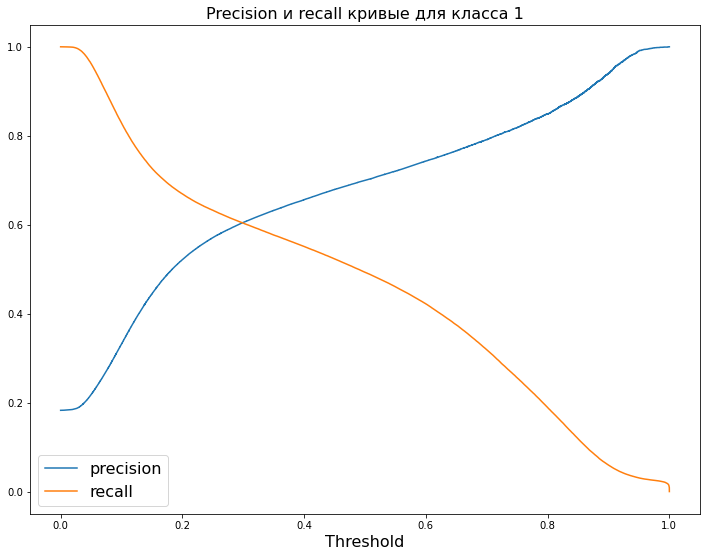

In [19]:
plot_pr_curve(y_val, model.predict(x_val))

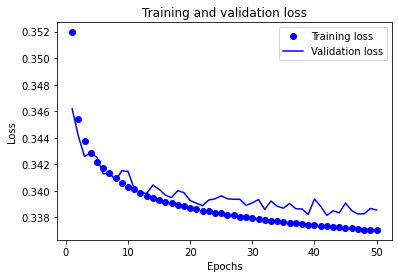

In [20]:
plot_train_val_loss(history_9, 50)

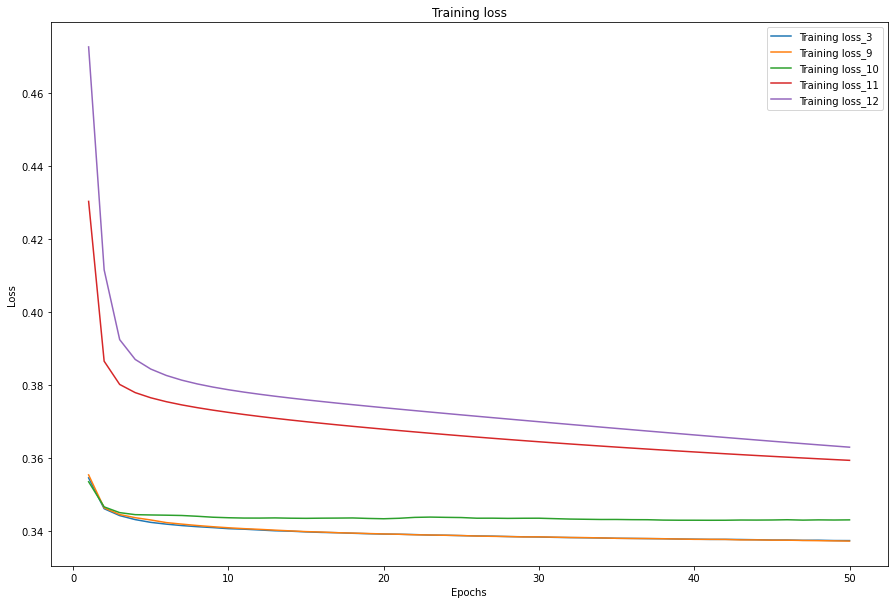

In [22]:
history_3_dict = history_3.history
history_9_dict = history_9.history
history_10_dict = history_10.history
history_11_dict = history_11.history
history_12_dict = history_12.history

loss_3_values = history_3_dict['loss']
val_loss_3_values = history_3_dict['val_loss']

loss_9_values = history_9_dict['loss']
val_loss_9_values = history_9_dict['val_loss']

loss_10_values = history_10_dict['loss']
val_loss_10_values = history_10_dict['val_loss']

loss_11_values = history_11_dict['loss']
val_loss_11_values = history_11_dict['val_loss']

loss_12_values = history_12_dict['loss']
val_loss_12_values = history_12_dict['val_loss']

epochs = range(1, 50 + 1)
plt.figure(figsize=(15,10))
plt.plot(epochs, loss_3_values, label='Training loss_3')
plt.plot(epochs, loss_9_values, label='Training loss_9')
plt.plot(epochs, loss_10_values, label='Training loss_10')
plt.plot(epochs, loss_11_values, label='Training loss_11')
plt.plot(epochs, loss_12_values, label='Training loss_12')
plt.title('Training loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

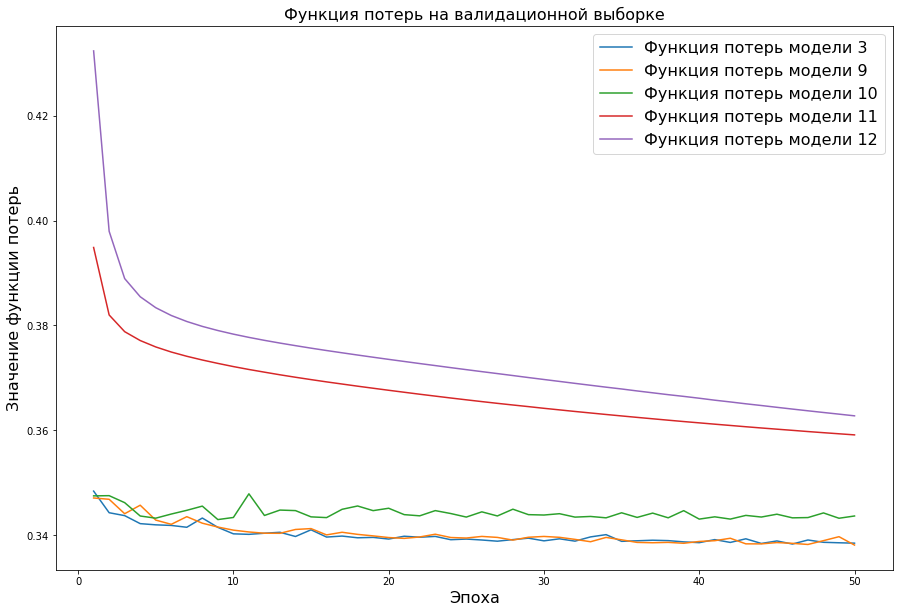

In [23]:
epochs = range(1, 50 + 1)
plt.figure(figsize=(15,10))
plt.plot(epochs, val_loss_3_values, label='Функция потерь модели 3')
plt.plot(epochs, val_loss_9_values, label='Функция потерь модели 9')
plt.plot(epochs, val_loss_10_values, label='Функция потерь модели 10')
plt.plot(epochs, val_loss_11_values, label='Функция потерь модели 11')
plt.plot(epochs, val_loss_12_values, label='Функция потерь модели 12')
plt.title('Функция потерь на валидационной выборке', fontsize=16)
plt.xlabel('Эпоха', fontsize=16)
plt.ylabel('Значение функции потерь', fontsize=16)
plt.legend(fontsize=16)

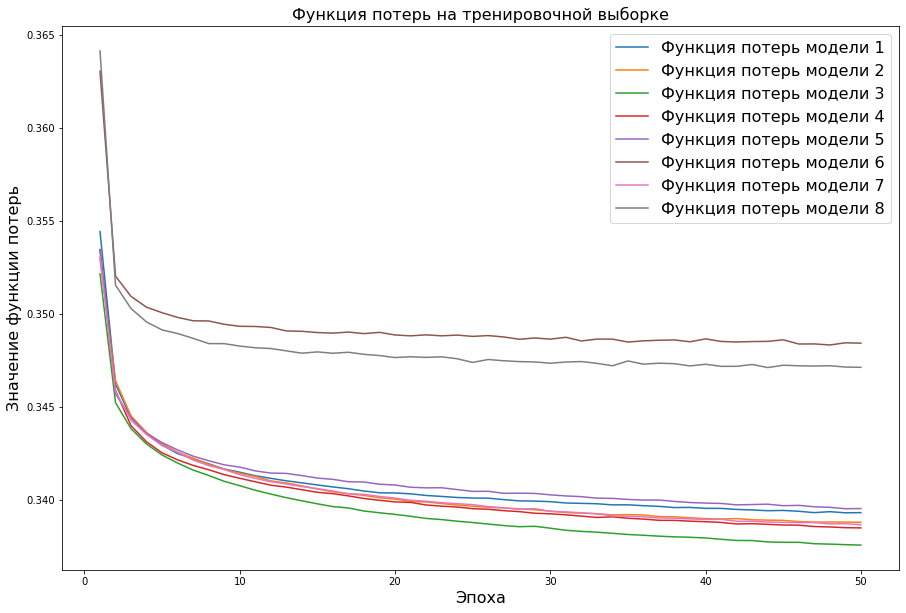

In [28]:
history_1_dict = history_1.history
history_2_dict = history_2.history
history_3_dict = history_3.history
history_4_dict = history_4.history
history_5_dict = history_5.history
history_6_dict = history_6.history
history_7_dict = history_7.history
history_8_dict = history_8.history

loss_1_values = history_1_dict['loss']
val_loss_1_values = history_1_dict['val_loss']

loss_2_values = history_2_dict['loss']
val_loss_2_values = history_2_dict['val_loss']

loss_3_values = history_3_dict['loss']
val_loss_3_values = history_3_dict['val_loss']

loss_4_values = history_4_dict['loss']
val_loss_4_values = history_4_dict['val_loss']

loss_5_values = history_5_dict['loss']
val_loss_5_values = history_5_dict['val_loss']

loss_6_values = history_6_dict['loss']
val_loss_6_values = history_6_dict['val_loss']

loss_7_values = history_7_dict['loss']
val_loss_7_values = history_7_dict['val_loss']

loss_8_values = history_8_dict['loss']
val_loss_8_values = history_8_dict['val_loss']

epochs = range(1, 50 + 1)
plt.figure(figsize=(15,10))
plt.plot(epochs, loss_1_values, label='Функция потерь модели 1')
plt.plot(epochs, loss_2_values, label='Функция потерь модели 2')
plt.plot(epochs, loss_3_values, label='Функция потерь модели 3')
plt.plot(epochs, loss_4_values, label='Функция потерь модели 4')
plt.plot(epochs, loss_5_values, label='Функция потерь модели 5')
plt.plot(epochs, loss_6_values, label='Функция потерь модели 6')
plt.plot(epochs, loss_7_values, label='Функция потерь модели 7')
plt.plot(epochs, loss_8_values, label='Функция потерь модели 8')
#plt.plot(epochs, val_loss_values, 'b', label='Validation loss')
plt.title('Функция потерь на тренировочной выборке', fontsize=16)
plt.xlabel('Эпоха', fontsize=16)
plt.ylabel('Значение функции потерь', fontsize=16)
plt.legend(fontsize=16)

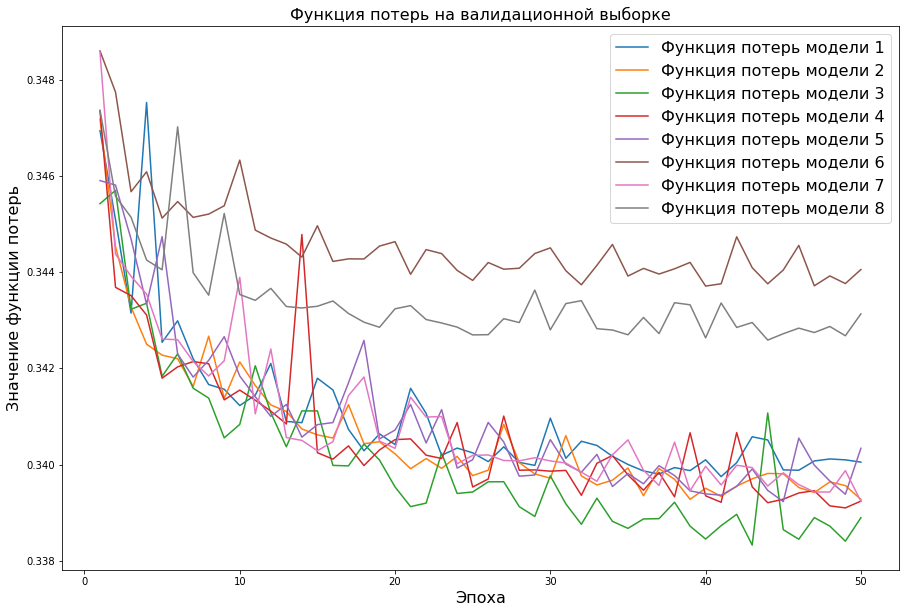

In [25]:
plt.figure(figsize=(15,10))
plt.plot(epochs, val_loss_1_values, label='Функция потерь модели 1')
plt.plot(epochs, val_loss_2_values, label='Функция потерь модели 2')
plt.plot(epochs, val_loss_3_values, label='Функция потерь модели 3')
plt.plot(epochs, val_loss_4_values, label='Функция потерь модели 4')
plt.plot(epochs, val_loss_5_values, label='Функция потерь модели 5')
plt.plot(epochs, val_loss_6_values, label='Функция потерь модели 6')
plt.plot(epochs, val_loss_7_values, label='Функция потерь модели 7')
plt.plot(epochs, val_loss_8_values, label='Функция потерь модели 8')
plt.title('Функция потерь на валидационной выборке', fontsize=16)
plt.xlabel('Эпоха', fontsize=16)
plt.ylabel('Значение функции потерь', fontsize=16)
plt.legend(fontsize=16)

### Классификатор с четырьмя скрытыми слоями

In [29]:
model = Sequential()
model.add(Dense(48, activation='relu', kernel_initializer='he_normal', input_shape=(x_train.shape[1],)))
model.add(Dropout(0.2))
model.add(Dense(48, activation='relu', kernel_initializer='he_normal'))
model.add(Dropout(0.2))
model.add(Dense(32, activation='relu', kernel_initializer='he_normal'))
model.add(Dense(32, activation='relu', kernel_initializer='he_normal'))
model.add(Dropout(0.2))
model.add(Dense(1,  activation='sigmoid', kernel_initializer='glorot_normal'))
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss='binary_crossentropy')
history_13 = model.fit(x_train, y_train, epochs=10, validation_data=(x_test, y_test), batch_size=256)

Epoch 1/10
10413/10413 [==============================] - 47s 4ms/step - loss: 0.3762 - val_loss: 0.3477
Epoch 2/10
10413/10413 [==============================] - 45s 4ms/step - loss: 0.3511 - val_loss: 0.3461
Epoch 3/10
10413/10413 [==============================] - 47s 5ms/step - loss: 0.3499 - val_loss: 0.3451
Epoch 4/10
10413/10413 [==============================] - 48s 5ms/step - loss: 0.3495 - val_loss: 0.3461
Epoch 5/10
10413/10413 [==============================] - 48s 5ms/step - loss: 0.3475 - val_loss: 0.3448
Epoch 6/10
10413/10413 [==============================] - 47s 4ms/step - loss: 0.3476 - val_loss: 0.3434
Epoch 7/10
10413/10413 [==============================] - 48s 5ms/step - loss: 0.3465 - val_loss: 0.3455
Epoch 8/10
10413/10413 [==============================] - 46s 4ms/step - loss: 0.3468 - val_loss: 0.3451
Epoch 9/10
10413/10413 [==============================] - 47s 5ms/step - loss: 0.3470 - val_loss: 0.3431
Epoch 10/10
10413/10413 [==============================

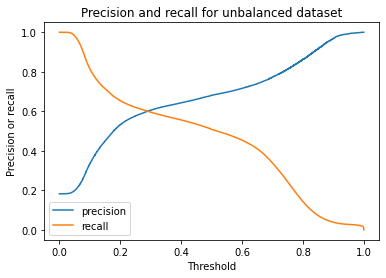

In [30]:
plot_pr_curve(y_val, model.predict(x_val))

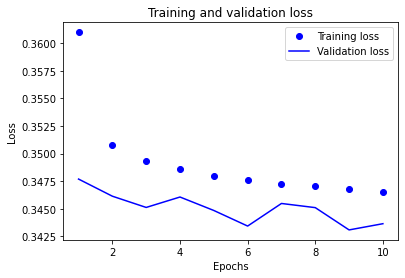

In [31]:
plot_train_val_loss(history_13, 10)

In [30]:
p_network = model.predict(x_val)

In [40]:
def asd(x):
    if x > 0.27:
        return 1
    return 0

In [41]:
test_score = []
for i in tqdm(range(len(y_val))):
    test_score.append(asd(p_network[i]))

100%|██████████| 888520/888520 [00:01<00:00, 449585.88it/s]


In [42]:
print(classification_report(y_val, test_score))

              precision    recall  f1-score   support

           0       0.91      0.91      0.91    726259
           1       0.60      0.61      0.60    162261

    accuracy                           0.85    888520
   macro avg       0.75      0.76      0.76    888520
weighted avg       0.85      0.85      0.85    888520



### Попробуем добиться переобучения на последней модели и применить регуляризацию

In [91]:
epochs = 100

In [92]:
model = Sequential()
model.add(Dense(32, activation='relu', input_shape=(x_train.shape[1],)))
model.add(Dense(32, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss='binary_crossentropy')
history_14 = model.fit(x_train, y_train, epochs=epochs, validation_data=(x_test, y_test), batch_size=256)

Epoch 1/100
10413/10413 [==============================] - 21s 2ms/step - loss: 0.3739 - val_loss: 0.3598
Epoch 2/100
10413/10413 [==============================] - 18s 2ms/step - loss: 0.3574 - val_loss: 0.3554
Epoch 3/100
10413/10413 [==============================] - 18s 2ms/step - loss: 0.3558 - val_loss: 0.3556
Epoch 4/100
10413/10413 [==============================] - 18s 2ms/step - loss: 0.3560 - val_loss: 0.3551
Epoch 5/100
10413/10413 [==============================] - 19s 2ms/step - loss: 0.3543 - val_loss: 0.3548
Epoch 6/100
10413/10413 [==============================] - 19s 2ms/step - loss: 0.3546 - val_loss: 0.3542
Epoch 7/100
10413/10413 [==============================] - 19s 2ms/step - loss: 0.3541 - val_loss: 0.3550
Epoch 8/100
10413/10413 [==============================] - 19s 2ms/step - loss: 0.3539 - val_loss: 0.3534
Epoch 9/100
10413/10413 [==============================] - 19s 2ms/step - loss: 0.3537 - val_loss: 0.3545
Epoch 10/100
10413/10413 [====================

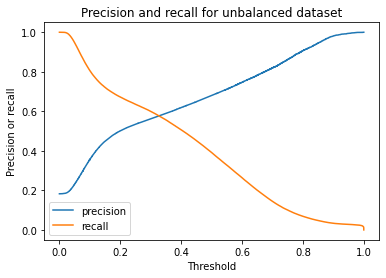

In [93]:
plot_pr_curve(y_val, model.predict(x_val))

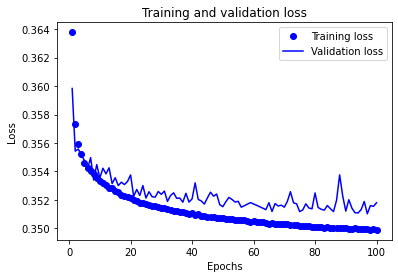

In [94]:
plot_train_val_loss(history_14, epochs)

In [20]:
model = Sequential()
model.add(Dense(32, activation='relu', kernel_initializer='he_normal', input_shape=(x_train.shape[1],)))
model.add(Dense(32, activation='relu', kernel_initializer='he_normal', 
                activity_regularizer=keras.regularizers.l1(1e-4)))
model.add(Dense(32, activation='relu', kernel_initializer='he_normal',
                activity_regularizer=keras.regularizers.l1(1e-4)))
model.add(Dense(1, activation='tanh', kernel_initializer='glorot_normal'))
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss='binary_crossentropy')
history_15 = model.fit(x_train, y_train, epochs=50, validation_data=(x_test, y_test), batch_size=256)

Epoch 1/50
10413/10413 [==============================] - 36s 3ms/step - loss: 0.3895 - val_loss: 0.3603
Epoch 2/50
10413/10413 [==============================] - 33s 3ms/step - loss: 0.3598 - val_loss: 0.3576
Epoch 3/50
10413/10413 [==============================] - 33s 3ms/step - loss: 0.3584 - val_loss: 0.3568
Epoch 4/50
10413/10413 [==============================] - 33s 3ms/step - loss: 0.3566 - val_loss: 0.3574
Epoch 5/50
10413/10413 [==============================] - 33s 3ms/step - loss: 0.3565 - val_loss: 0.3563
Epoch 6/50
10413/10413 [==============================] - 33s 3ms/step - loss: 0.3552 - val_loss: 0.3550
Epoch 7/50
10413/10413 [==============================] - 33s 3ms/step - loss: 0.3557 - val_loss: 0.3550
Epoch 8/50
10413/10413 [==============================] - 33s 3ms/step - loss: 0.3553 - val_loss: 0.3559
Epoch 9/50
10413/10413 [==============================] - 33s 3ms/step - loss: 0.3552 - val_loss: 0.3549
Epoch 10/50
10413/10413 [==============================

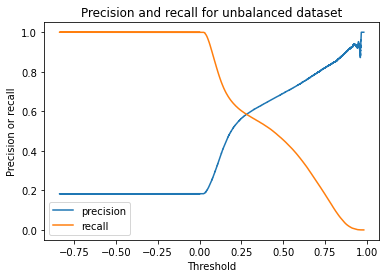

In [21]:
plot_pr_curve(y_val, model.predict(x_val))

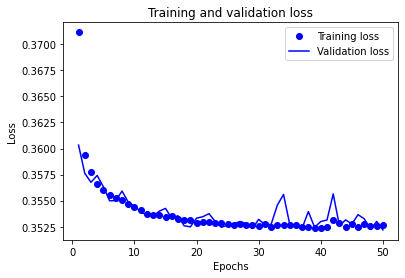

In [23]:
plot_train_val_loss(history_15, 50)

In [27]:
p_network = model.predict(x_val)

In [28]:
def asd(x):
    if x > 0.27:
        return 1
    return 0

In [29]:
test_score = []
for i in tqdm(range(len(y_val))):
    test_score.append(asd(p_network[i]))
    
print(classification_report(y_val, test_score))

100%|██████████| 888520/888520 [00:03<00:00, 250696.75it/s]


              precision    recall  f1-score   support

           0       0.91      0.91      0.91    726259
           1       0.60      0.61      0.60    162261

    accuracy                           0.85    888520
   macro avg       0.76      0.76      0.76    888520
weighted avg       0.86      0.85      0.86    888520



### Автокодировщик

In [12]:
autoencoder = Sequential()
autoencoder.add(Dense(32, activation='relu', input_shape=(x_train.shape[1],)))
autoencoder.add(Dense(16, activation='relu', activity_regularizer=keras.regularizers.l1(10e-8)))
autoencoder.add(Dense(32, activation='relu', activity_regularizer=keras.regularizers.l1(10e-8)))
autoencoder.add(Dense(x_train.shape[1], activation='sigmoid'))
autoencoder.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss='binary_crossentropy')
autoencoder.fit(x_train[y_train==0], x_train[y_train==0], epochs=100, batch_size=256)

Epoch 1/100
8511/8511 [==============================] - 28s 3ms/step - loss: 0.4017
Epoch 2/100
8511/8511 [==============================] - 25s 3ms/step - loss: 0.3636
Epoch 3/100
8511/8511 [==============================] - 25s 3ms/step - loss: 0.3599
Epoch 4/100
8511/8511 [==============================] - 25s 3ms/step - loss: 0.3580
Epoch 5/100
8511/8511 [==============================] - 25s 3ms/step - loss: 0.3576
Epoch 6/100
8511/8511 [==============================] - 25s 3ms/step - loss: 0.3575
Epoch 7/100
8511/8511 [==============================] - 25s 3ms/step - loss: 0.3574
Epoch 8/100
8511/8511 [==============================] - 25s 3ms/step - loss: 0.3573
Epoch 9/100
8511/8511 [==============================] - 25s 3ms/step - loss: 0.3573
Epoch 10/100
8511/8511 [==============================] - 25s 3ms/step - loss: 0.3573
Epoch 11/100
8511/8511 [==============================] - 25s 3ms/step - loss: 0.3573
Epoch 12/100
8511/8511 [==============================] - 25s 3

In [13]:
test_x_predictions = autoencoder.predict(x_test)
mse = x_test - test_x_predictions

In [14]:
%%time
grad = XGBClassifier(n_estimators=100, random_state=42, n_jobs=6, 
                     learning_rate=0.3, use_label_encoder=False)
grad.fit(mse, y_test)

[22:43:40] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
CPU times: user 55min 27s, sys: 0 ns, total: 55min 27s
Wall time: 9min 21s


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.3, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=6, num_parallel_tree=1, random_state=42,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', use_label_encoder=False,
              validate_parameters=1, verbosity=None)

In [15]:
valid_x_predictions = autoencoder.predict(x_val)
mse = x_val - valid_x_predictions
print(classification_report(y_val, grad.predict(mse)))

              precision    recall  f1-score   support

           0       0.89      0.96      0.92    726259
           1       0.69      0.45      0.54    162261

    accuracy                           0.86    888520
   macro avg       0.79      0.70      0.73    888520
weighted avg       0.85      0.86      0.85    888520



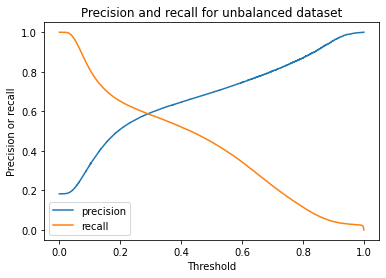

In [16]:
plot_pr_curve(y_val, grad.predict_proba(mse)[:, 1])

In [67]:
def asd(x):
    if x > 0.3:
        return 1
    return 0

In [68]:
p_network = grad.predict_proba(mse)[:, 1]
test_score = []
for i in tqdm(range(len(y_val))):
    test_score.append(asd(p_network[i]))
    
print(classification_report(y_val, test_score))

100%|██████████| 888520/888520 [00:02<00:00, 383322.81it/s]


              precision    recall  f1-score   support

           0       0.91      0.90      0.90    726259
           1       0.57      0.59      0.58    162261

    accuracy                           0.84    888520
   macro avg       0.74      0.74      0.74    888520
weighted avg       0.85      0.84      0.85    888520



Классификатор сработал лучше

In [12]:
import numpy as np
from keras.layers import Conv1D, MaxPooling1D, UpSampling1D, Input, Dense
from keras.datasets import mnist
from keras.models import Model, Sequential

In [57]:
x_train.shape

(2665560, 52)

In [58]:
model = Sequential()

model.add(Conv1D(64, kernel_size=4, padding='same', input_shape = (52,1), activation='relu'))
model.add(MaxPooling1D(2, padding='same'))
model.add(Conv1D(32, kernel_size=4, padding='same', activation='relu'))
model.add(MaxPooling1D(2, padding='same'))
model.add(Conv1D(1, kernel_size=4, padding='same', activation='relu'))

model.add(Conv1D(32, kernel_size=4, padding='same', activation='relu'))
model.add(UpSampling1D(2))
model.add(Conv1D(64, kernel_size=4, padding='same', activation='relu'))
model.add(UpSampling1D(2))
model.add(Conv1D(1, kernel_size=4, padding='same', activation='sigmoid'))

model.summary()

Model: "sequential_34"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_194 (Conv1D)          (None, 52, 64)            320       
_________________________________________________________________
max_pooling1d_67 (MaxPooling (None, 26, 64)            0         
_________________________________________________________________
conv1d_195 (Conv1D)          (None, 26, 32)            8224      
_________________________________________________________________
max_pooling1d_68 (MaxPooling (None, 13, 32)            0         
_________________________________________________________________
conv1d_196 (Conv1D)          (None, 13, 1)             129       
_________________________________________________________________
conv1d_197 (Conv1D)          (None, 13, 32)            160       
_________________________________________________________________
up_sampling1d_64 (UpSampling (None, 26, 32)          

In [59]:
model.compile(optimizer='adam', loss='binary_crossentropy')
model.fit(x_train[y_train==0].reshape(-1,52,1), x_train[y_train==0].reshape(-1,52,1),
          epochs=25, batch_size=256, shuffle=True)

Epoch 1/25
8511/8511 [==============================] - 323s 38ms/step - loss: 0.4110
Epoch 2/25
8511/8511 [==============================] - 320s 38ms/step - loss: 0.3831
Epoch 3/25
8511/8511 [==============================] - 323s 38ms/step - loss: 0.3797
Epoch 4/25
8511/8511 [==============================] - 326s 38ms/step - loss: 0.3779
Epoch 5/25
8511/8511 [==============================] - 321s 38ms/step - loss: 0.3767
Epoch 6/25
8511/8511 [==============================] - 321s 38ms/step - loss: 0.3758
Epoch 7/25
8511/8511 [==============================] - 321s 38ms/step - loss: 0.3750
Epoch 8/25
8511/8511 [==============================] - 321s 38ms/step - loss: 0.3745
Epoch 9/25
8511/8511 [==============================] - 324s 38ms/step - loss: 0.3740
Epoch 10/25
8511/8511 [==============================] - 325s 38ms/step - loss: 0.3737
Epoch 11/25
8511/8511 [==============================] - 325s 38ms/step - loss: 0.3734
Epoch 12/25
8511/8511 [=============================

In [60]:
test_x_predictions = model.predict(x_test.reshape(-1,52,1))

In [61]:
test_x_predictions.shape

(1184694, 52, 1)

In [62]:
test_x_predictions.reshape(-1,52).shape

(1184694, 52)

In [63]:
mse = x_test - test_x_predictions.reshape(-1,52)

In [64]:
%%time
grad = XGBClassifier(n_estimators=100, random_state=42, n_jobs=6, 
                     learning_rate=0.3, use_label_encoder=False)
grad.fit(mse, y_test)

[14:54:43] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
CPU times: user 40min 21s, sys: 5.75 s, total: 40min 27s
Wall time: 6min 45s


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.3, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=6, num_parallel_tree=1, random_state=42,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', use_label_encoder=False,
              validate_parameters=1, verbosity=None)

In [65]:
valid_x_predictions = model.predict(x_val.reshape(-1,52,1))
mse = x_val - valid_x_predictions.reshape(-1,52)
print(classification_report(y_val, grad.predict(mse)))

              precision    recall  f1-score   support

           0       0.88      0.96      0.92    726259
           1       0.69      0.41      0.52    162261

    accuracy                           0.86    888520
   macro avg       0.78      0.69      0.72    888520
weighted avg       0.84      0.86      0.84    888520



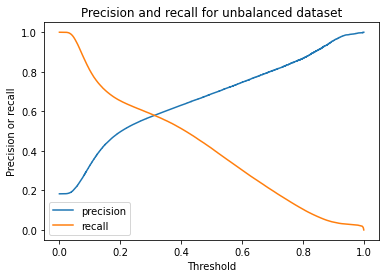

In [66]:
plot_pr_curve(y_val, grad.predict_proba(mse)[:, 1])